In [1]:
#pip install opencv-python
import cv2
import numpy as np
import os 
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = '/home/yerkebulan/app/dev/projects/classification_research/dogs-vs-cats/train'
TEST_DIR = '/home/yerkebulan/app/dev/projects/classification_research/dogs-vs-cats/test1'
IMG_SIZE = 50
LR = 1e-3
EPOCHE = 10

MODEL_NAME = 'dog_vs_cat-{}-{}.model'.format(LR, '8conv-10epoche')

In [2]:
# [catness, dogness]
def label_image(img):
    label = img.split('.')[-3]
    if label == 'cat':
        return [1,0]
    else:
        return [0,1]

In [3]:
def create_train_data():
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_image(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data)
    return train_data

In [4]:
for img in tqdm(os.listdir(TRAIN_DIR)):
    print(type(img))
    break;

  0%|          | 0/25000 [00:00<?, ?it/s]

<class 'str'>


In [5]:
def create_test_data():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_id = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        test_data.append([np.array(img), img_id])
    np.save('test_data.npy', test_data)
    return test_data
    

In [6]:
# train_data = create_train_data()
# if you already run this function
train_data = np.load('train_data.npy')

In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

#layer
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

#layer
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

#layer
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

#layer
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

#layer
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

#layer
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

#layer
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

#layer
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [8]:
train_data[0][0].shape

(50, 50)

In [9]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('EXISTING MODEL LOADED!!!')

# Processing

In [10]:
train = train_data[:-500]
test = train_data[-500:]

In [11]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

# Training

In [12]:
model.fit(
    {'input': X}, 
    {'targets': Y}, 
    n_epoch=EPOCHE, 
    validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME
)

Training Step: 3829  | total loss: 0.30286 | time: 66.426s
| Adam | epoch: 010 | loss: 0.30286 - acc: 0.8592 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.31473 | time: 67.584s
| Adam | epoch: 010 | loss: 0.31473 - acc: 0.8608 | val_loss: 0.45031 - val_acc: 0.8120 -- iter: 24500/24500
--


In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/yerkebulan/app/dev/projects/classification_backend/classifications/classification_research/dog_vs_cat-0.001-8conv-10epoche.model is not in all_model_checkpoint_paths. Manually adding it.


In [14]:
#tensorboard --logdir=foo:/home/yerkebulan/app/dev/projects/classification_research/log

# Testing

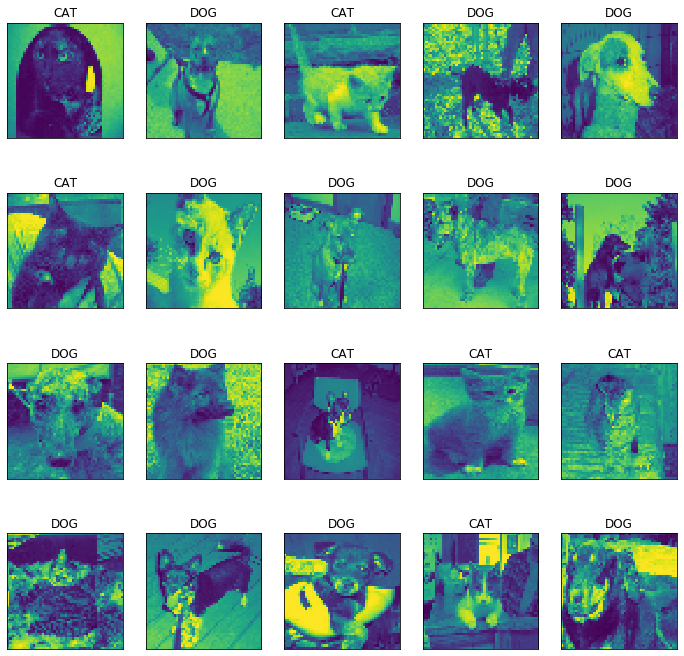

In [19]:
import matplotlib.pyplot as plt
# need to load_data
# test_data = create_test_data()
# if already created
test_data = np.load('test_data.npy')

fig = plt.figure(figsize=(12, 12))

for i, data in enumerate(test_data[80:100]):
    # cat = [1,0]
    # dog = [0,1]
    img_id = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4,5,i+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    prediction = model.predict([data])[0]
    
    label = 'CAT'
    if np.argmax(prediction) == 1:
        label = 'DOG'
    y.imshow(orig)
    plt.title(label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()


In [16]:
with open('submission-file.csv', 'w') as f:
    f.write('id,label\n')

In [17]:
with open('submission-file.csv', 'a') as f:
    for data in tqdm(test_data):
        img_id = data[1]
        img_data = data[0]

        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)

        prediction = model.predict([data])[0]
        f.write('{},{}\n'.format(img_id, prediction[1]))

100%|██████████| 12500/12500 [00:16<00:00, 774.82it/s]
